# Example 12: Compare impact of frequency dependent $D_{min}$

In [ ]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pystrata

%matplotlib inline

In [ ]:
plt.rcParams["figure.dpi"] = 150

## Damping calculation

In [ ]:
plast_indices = [0, 20, 50, 100]
stresses_mean = 101.3 * np.array([0.5, 1, 2])
ocrs = [1, 2, 4]
freqs = np.logspace(-1, 2, num=31)

df = pd.DataFrame(
    itertools.product(freqs, stresses_mean, plast_indices, ocrs),
    columns=["freq", "stress_mean", "plast_ind", "ocr"],
)

In [ ]:
def calc_damp_min(row):
    return pystrata.site.DarendeliSoilType(
        plas_index=row.plast_ind,
        stress_mean=row.stress_mean,
        ocr=row.ocr,
        freq=row.freq,
    )._calc_damping_min()


df["damp_min"] = df.apply(calc_damp_min, axis=1)

In [ ]:
df.head()

,freq,stress_mean,plast_ind,ocr,damp_min
0,0.1,50.65,0,1,0.003207
1,0.1,50.65,0,2,0.003207
2,0.1,50.65,0,4,0.003207
3,0.1,50.65,20,1,0.004240
4,0.1,50.65,20,2,0.004167


In [ ]:
centers = {"plast_ind": 20, "stress_mean": 101.3, "ocr": 1}

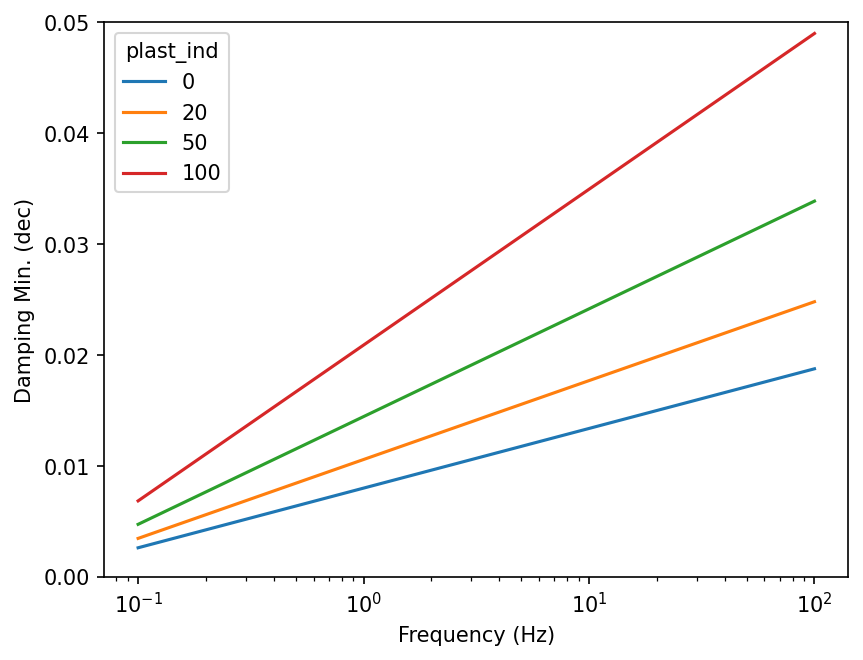

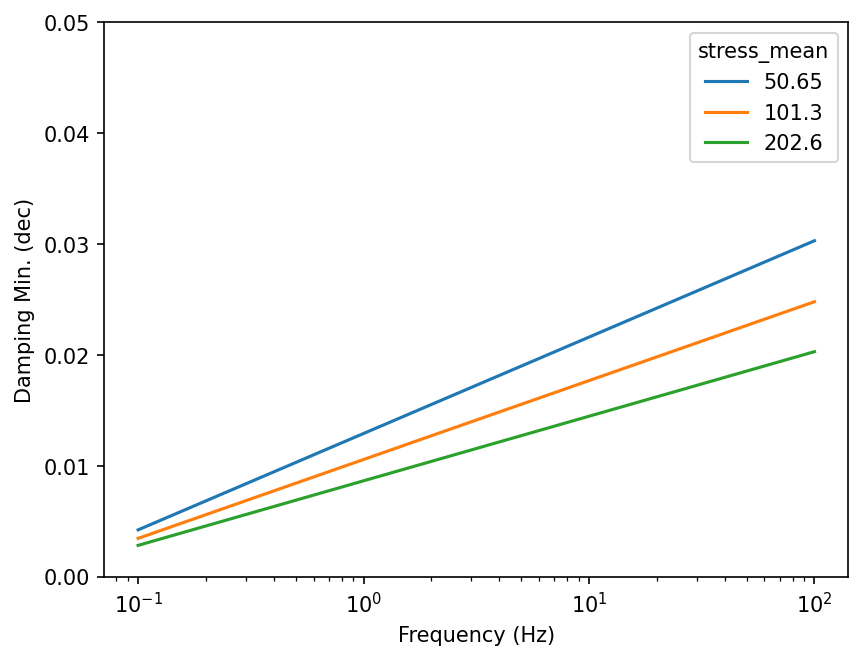

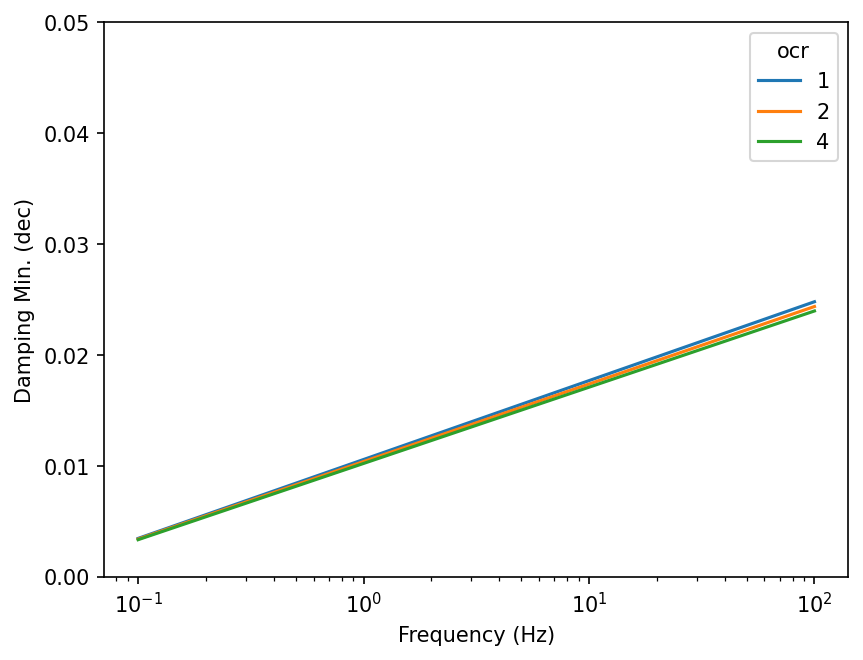

In [ ]:
for key in centers:
    # Only select the centers
    mask = np.all([df[k].eq(v) for k, v in centers.items() if k != key], axis=0)
    selected = df[mask]

    fig, ax = plt.subplots()
    for name, group in selected.groupby(key):
        ax.plot(group["freq"], group["damp_min"], label=name)
    ax.set(
        xlabel="Frequency (Hz)",
        xscale="log",
        ylabel="Damping Min. (dec)",
        ylim=(0, 0.05),
    )
    ax.legend(title=key)

## Site Response Calculation

### Input

In [ ]:
motion = pystrata.motion.SourceTheoryRvtMotion(7.0, 30, "wna")
motion.calc_fourier_amps()

Two profiles are created. The first is a typical profile with the minimum damping computed at 1 Hz (default value). The second profile has the minimum damping computed at each frequency of the input motion.

In [ ]:
profiles = [
    # Frequency independent soil properties
    pystrata.site.Profile(
        [
            pystrata.site.Layer(
                pystrata.site.DarendeliSoilType(
                    18.0, plas_index=30, ocr=1, stress_mean=200
                ),
                30,
                400,
            ),
            pystrata.site.Layer(
                pystrata.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200
            ),
        ]
    ),
    # Frequency dependent minimum damping
    pystrata.site.Profile(
        [
            pystrata.site.Layer(
                pystrata.site.DarendeliSoilType(
                    18.0, plas_index=30, ocr=1, stress_mean=200, freq=motion.freqs
                ),
                30,
                400,
            ),
            pystrata.site.Layer(
                pystrata.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200
            ),
        ]
    ),
]

profiles = [p.auto_discretize() for p in profiles]

In [ ]:
calc_fdm = pystrata.propagation.FrequencyDependentEqlCalculator(
    method="raw"
)
calc_eql = pystrata.propagation.EquivalentLinearCalculator(strain_ratio=0.65)

In [ ]:
freqs = np.logspace(-1, 2, num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.AccelTransferFunctionOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
        ),
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
    ]
)

### Run the analyses and save the output.

In [ ]:
for name, profile in zip(
    ["FDM - Constant $D_{min}$", "FDM - Variable $D_{min}$"], profiles
):
    calc_fdm(motion, profile, profile.location("outcrop", index=-1))
    outputs(calc_fdm, name)

calc_eql(motion, profiles[0], profiles[0].location("outcrop", index=-1))
outputs(calc_eql, "EQL")

### Plot the results

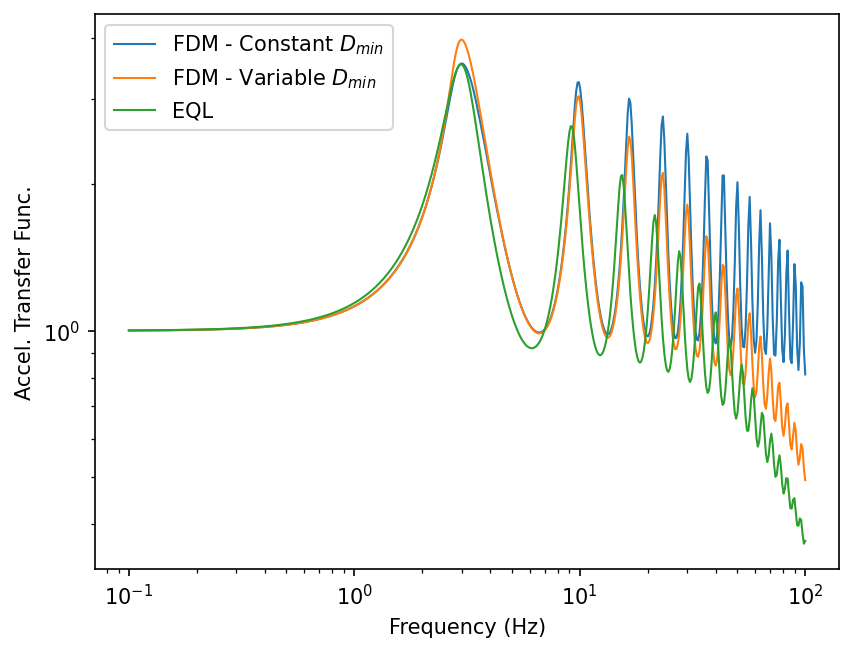

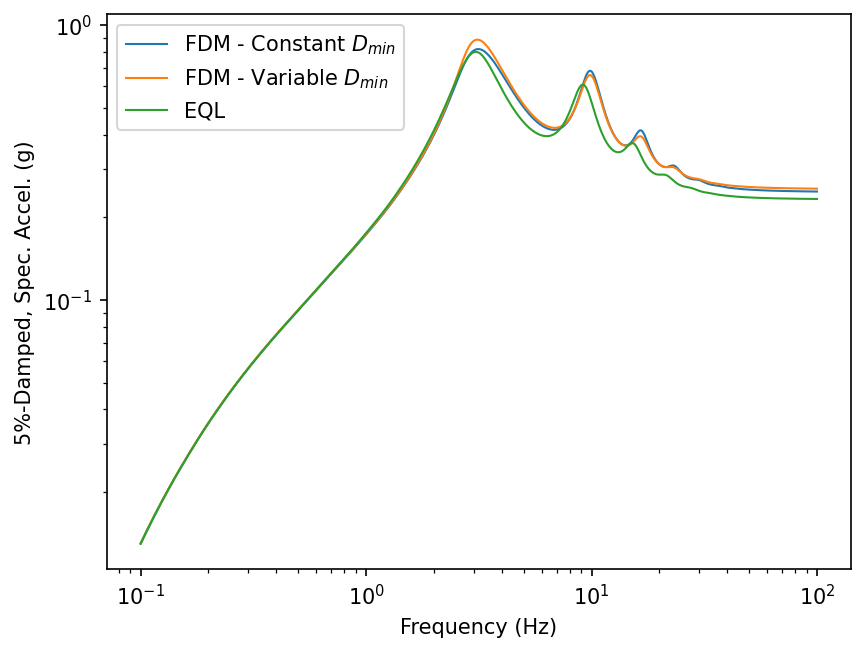

In [ ]:
for o in outputs:
    o.plot(style="indiv")